In [1]:
import finesse
import time
import asyncio
import numpy as np
from finesse.solutions import BaseSolution
from copy import deepcopy
from finesse.analysis.runners import run_axes_scan
from finesse.solutions import ArraySolution
from finesse import _CONFIG

import logging
LOGGER = logging.getLogger(__name__)


finesse.init_plotting()
    
class AnalysisStepInfo(finesse.solutions.TreeNode):
    def __init__(self, name=None, makes_solution=False, parameters_changing=tuple(), parent=None):
        if (name is None and makes_solution == True):
            raise Exception("A name must be supplied if a solution is produced.")
        super().__init__(name, parent)
        self.makes_a_solution = makes_solution
        self.parameters_changing = parameters_changing
        
def process_yield(info):
    """
    This is a helper function with the analysis coroutines should yield
    from when getting their inputs. This method checks if this is an 
    initial run of the analysis. At first the analyses must provide
    some initial information about what they will be doing to the model.
    This is then used to build the model in an efficient way so that
    it shouldn't need to be rebuilt for each analysis.
    
    If an analysis is reused then the new run method will request new
    `AnalysisStepInfo` which should be returned. As there is possibility
    that the coroutines have some state (such as keeping track of steps
    completed, or figure to plot to) a reset flag is returned if this
    happens.
    """
    
    vals = (yield)
    info_yield = isinstance(vals, AnalysisStepInfo)
    reset = False
    
    while isinstance(vals, AnalysisStepInfo):
        # add step to the parent
        info.parent = vals
        # Need to return a complete copy of info here otherwise
        # the AnalysisInfo tree that run wants to create gets
        # infinite loops in it
        vals.children.append(deepcopy(info))
        reset = True
        vals = (yield)
        
    return (*vals[:2], reset)

def coroutine(func):
    """
    Function decarator to declare they are a coroutine.
    """
    def start(*args, **kwargs):
        "Helper function to start a coroutine"
        cr = func(*args, **kwargs)
        next(cr)
        return cr
    return start
    
def run(model, cr, build_kwargs={}):
    """
    Runs a model through a coroutine analysis.
    
    Parameters
    ----------
    model : `.class`finesse.model
        Model to analyse
    
    cr : coroutine
        Coroutine function to apply the model to
    
    Returns
    -------
    `.class`.Solution
    """
    if model.is_built:
        raise Exception("Model is currently built")
    
    carrier = signal = None
    
    try:
        # Create a top level information object and pass that
        # along to all the coroutines so we can find out what's
        # happening
        info = AnalysisStepInfo()
        cr.send(info)
        
        params = (model.reduce_get_attr(pstr)
                  for pstr in info.get_all_parameters_changing())
        
        for p in params:
            p.is_tunable = True
        
        sims = model.build(**build_kwargs)
        
        if len(sims) == 1:
            carrier, signal = sims[0], None
        elif len(sims) == 2:
            carrier, signal = sims
        else:
            raise Exception("Unexpected number of Simulation objects")
        
        carrier.__enter__()
        if signal is not None:
            signal.__enter__()

        s = BaseSolution(None, None)
        cr.send((s, model))
            
    except StopIteration:
        raise Exception("Should we reach this point? Probably unexpected")
    
    finally:
        if carrier is not None:
            carrier.__exit__(None, None, None)
        if signal is not None:
            signal.__exit__(None, None, None)

        model.unbuild()

        for p in params:
            p.is_tunable = False

    return s
            
@coroutine
def folder(name, cr):
    info = AnalysisStepInfo(name=name)
    cr.send(info)
    folder = None
    
    while True:
        s_prev, model, reset = (yield from process_yield(info))
        
        if reset:
            folder = BaseSolution(name, s_prev)
            
        cr.send((folder, model))
     
@coroutine
def incremental_folder(name, cr):
    """
    This coroutine is similar to `folder` which allows solutions to be organised.
    Using this coroutine however will put each solution that is calculated for this
    folder into its own subfolder that is incremented by an integer each time it is
    called.
    """
    info = AnalysisStepInfo(name=name)
    cr.send(info)
    i = 0
    folder1 = None
    
    while True:
        s_prev, model, reset = (yield from process_yield(info))
        # Maybe there is a nicer way to catch the fact
        # that this analysis is being applied to a new model
        if reset:
            i = 0
            folder1 = None
            
        if folder1 is None:
            folder1 = BaseSolution(name, s_prev)
            
        folderi = BaseSolution(str(i), folder1)
        cr.send((folderi, model))
        i += 1
        
@coroutine
def plot():  
    info = AnalysisStepInfo()
    while True:
        sol, model, reset = (yield from process_yield(info))
        while type(sol) is BaseSolution:
            sol = sol.parent
            
        if sol is not None and hasattr(sol, 'plot'):
            sol.plot()
        else:
            print("No plot method")
            
@coroutine
def printer(prefix="", ):
    info = AnalysisStepInfo()
    while True:
        vals = (yield from process_yield(info))
        print(f"{prefix}", vals)
        
@coroutine
def print_attr(*args):
    info = AnalysisStepInfo()
    while True:
        s_prev, model, reset = (yield from process_yield(info))
        print(*(f"{_}={model.reduce_get_attr(_)}" for _ in args))
        
@coroutine
def repr_attr(*args):
    info = AnalysisStepInfo()
    while True:
        s_prev, model, reset = (yield from process_yield(info))
        print(*(f"{_}={repr(model.reduce_get_attr(_))}" for _ in args))
        
@coroutine
def custom(func, on_done=None):
    """
    An analysis coroutine for running a custom function. This allows
    a user to inject some customised process to happen during an analysis.
    The function accepts the current solution state.
    
    Parameters
    ----------
    func : Callable(`.class`finesse.analysis.solution, `.class`finesse.Model)
        Callable expecting a solution and model to operate on. 
    
    Receives
    --------
    (Solution, `.class`finesse.Model)
    
    Sends
    -----
    Sends (Solution, `.class`finesse.Model), after it has passed through `func` to
    the `on_done` coroutine.
    
    """
    info = AnalysisStepInfo()
    
    while True:
        s_prev, model, reset = (yield from process_yield(info))
        func(*vals)
        
        if on_done:
            on_done.send(vals)
            
@coroutine
def parallel(*args, parallelise=False):
    """
    An analysis coroutine which deepcopies the incoming `.class`finesse.Model
    and passes it to each coroutine passed in `args`. 
    
    Each coroutine in `args` should be considered to be completely independent
    of one another, and could run in separate processes.
    
    TODO
    ----
    Research into using Ray, Dask, Ipyparallel here.
    
    Parameters
    ----------
    *args : (Coroutine, Coroutine, ...)
        Coroutines to run in parallel
        
    parallelise : Boolean
        (Not implemented) If `True`, this will run each coroutine in a separate process
    
    Receives
    --------
    (Solution, `.class`finesse.Model)
    
    Sends
    -----
    To each coroutines in `*args`: (Solution, `.class`finesse.Model)
    """
    pinfo = (yield) # parent info
    
    for arg in args:
        arg.send(pinfo)
            
    while True:
        vals = (yield)
        s_prev, model = vals
        
        # TODO: need to check the model is stopped so we can deepcopy it I think
        
        for arg in args:
            m = deepcopy(model)
            arg.send((s_prev, m))
            
            
@coroutine
def serial(*args):
    """
    An analysis coroutine which takes the incoming `.class`finesse.Model
    and passes it to each coroutine passed in `args` in series. 
    
    The `.class`finesse.Model will kept at the end of each analysis and
    passed to the next.
    
    Parameters
    ----------
    *args : (Coroutine, Coroutine, ...)
    
    Receives
    --------
    (Solution, `.class`finesse.Model)
    
    Sends
    -----
    To each coroutines in `*args`: (Solution, `.class`finesse.Model)
    """
    pinfo = (yield) # parent info
    
    for arg in args:
        arg.send(pinfo)
        if len(pinfo.children) > 0:
            # If a solution was made and added as a child in the previous coroutine
            # then that becomes the next solution in the serial chain
            pinfo = pinfo.children[-1]
                
    while True:
        sol, model = (yield)
        
        for arg in args:
            arg.send((sol, model))
            
            if len(sol.children) > 0:
                # If a solution was made and added as a child in the previous coroutine
                # then that becomes the next solution in the serial chain
                sol = sol.children[-1]
        
@coroutine
def step_along(name, *args, pre_step=None, post_step=None, on_complete=None, build_kwargs={}):
    if len(args) % 3 != 0:
        raise Exception(
            "Arguments must be triples of parameter, array of "
            "values to scan over, and offset to array values."
        )

    params_str = args[::3]
    axes = tuple(np.atleast_1d(_) for _ in args[1::3])
    offsets = args[2::3]
    LOGGER.info("Scanning parameters %s", list(params_str))
    out_shape = tuple(np.size(_) for _ in axes)
    
    info = AnalysisStepInfo(name=name,
                            makes_solution=True,
                            parameters_changing=params_str)
    
    if pre_step is not None:
        folder_pre_step = incremental_folder('pre', pre_step)
        folder_pre_step.send(info)
    else:
        folder_pre_step = None
        
    if post_step is not None:
        folder_post_step = incremental_folder('post', post_step)
        folder_post_step.send(info)
    else:
        folder_post_step = None

    if on_complete:
        folder_on_complete = folder('on_complete', on_complete)
        folder_on_complete.send(info)
        
    while True:
        # Sit and wait for a model to come in
        s_prev, model, reset = (yield from process_yield(info))

        if reset:
            # As we define the folder coroutines in this function
            # we have to make sure we pass any reset to them here
            # as they won't be part of the usual tree
            if post_step:
                folder_post_step.send(info)
            if on_complete:
                folder_on_complete.send(info)
                
        params = tuple(model.reduce_get_attr(p) for p in params_str)
        assert(model.is_built)
        
        if len(args) > 0:
            for p in params:
                if not p.is_tunable:
                    raise ParameterLocked(
                        f"{repr(p)} must set as tunable "
                        "before building the simulation"
                    )

        carrier = model.carrier_simulation
        
        try:
            signal = model.signal_simulation
        except AttributeError:
            signal = None
        
        s = ArraySolution(name, s_prev, model, out_shape)

        for lock in model.locks:
            raise NotImplemented()
            # TODO Surely lock can just get the sims from the
            # the model?
            lock.set_sim_handles(carrier, signal)
            # This also needs to be moved somewhere other than here
            lock.feedback_param.is_tunable = True

        locksteps = _CONFIG["locks"].getint("locksteps")

        for i, (value, param) in enumerate(zip(axes, params)):
            setattr(s, f"x{i+1}", value)
            # TODO : This needs to be changed to a param string rather than a parameter reference
            setattr(s, f"p{i+1}", param)

        # Now we loop over the actual simulation and run each point
        run_axes_scan(
            carrier,
            signal,
            axes,
            params,
            offsets,
            out_shape,
            model.locks,
            s,
            locksteps,
            folder_pre_step,
            folder_post_step
        )    

        if on_complete:
            folder_on_complete.send((s, model))

In [4]:
import finesse.analysis

In [2]:
kat = finesse.Kat()
kat.parse("""
l l1 P=1 f=0
s s1 l1.p1 m1.p1
m m1 0.5 0.1 0

pd Pr m1.p1.o
pd Pt m1.p2.o
""")

In [3]:
xp1 = parallel(
                step_along('tune1', 'l1.P', np.linspace(0, 2, 4), False),
                step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False)
              )

sol = run(kat.model, xp1)
print(sol.get('/').children)

Exception: Simulation objects can not be deepcopied

In [4]:
x12 = step_along('tune1', 'l1.P', np.linspace(0, 2, 4), False,
         post_step=step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False))

sol = run(kat.model, x12)
print(sol.get('tune1/post').children)

# Check if this all still works even if we reuse the analysis
sol = run(kat.model, x12)
print(sol.get('tune1/post').children)

[<BaseSolution of /tune1/post/0 @ 0x116d437f0 children=1>, <BaseSolution of /tune1/post/1 @ 0x116d43940 children=1>, <BaseSolution of /tune1/post/2 @ 0x116d43a20 children=1>, <BaseSolution of /tune1/post/3 @ 0x116d43b00 children=1>]
[<BaseSolution of /tune1/post/0 @ 0x116d51908 children=1>, <BaseSolution of /tune1/post/1 @ 0x116d51a58 children=1>, <BaseSolution of /tune1/post/2 @ 0x116d51b38 children=1>, <BaseSolution of /tune1/post/3 @ 0x116d51c18 children=1>]


In [30]:
sol.ls('tune1/post')

['tune1/post/0', 'tune1/post/1', 'tune1/post/2', 'tune1/post/3']


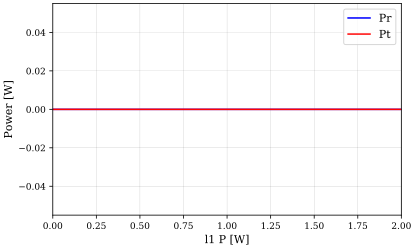

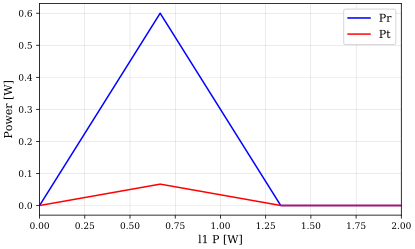

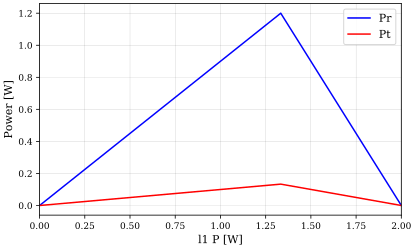

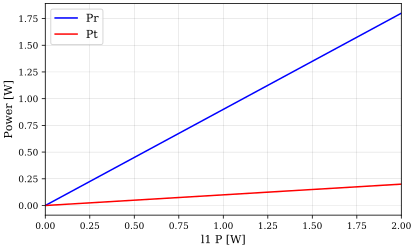

[<BaseSolution of /tune1/post/0 @ 0x11f0f5d68 children=1>,
 <BaseSolution of /tune1/post/1 @ 0x11f616390 children=1>,
 <BaseSolution of /tune1/post/2 @ 0x120234da0 children=1>,
 <BaseSolution of /tune1/post/3 @ 0x11ff46f98 children=1>]

In [34]:
x1 = step_along('tune1', 'l1.P', np.linspace(0, 2, 4), False,
         post_step=serial(plot(),
                          step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False))
         )

sol = run(kat.model, x1)

sol.get('tune1/post').children

In [17]:
x1 = step_along('tune1', 'l1.P', np.linspace(1, 4, 4), False,
         post_step=serial(repr_attr('l1.P'), step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False))
         )

sol = run(kat.model, x1)

sol.get('tune1/post').children

l1.P=<l1.P=1.0 @ 0x11f8e2710>
l1.P=<l1.P=2.0 @ 0x11f8e2710>
l1.P=<l1.P=3.0 @ 0x11f8e2710>
l1.P=<l1.P=4.0 @ 0x11f8e2710>


[<BaseSolution of /tune1/post/0 @ 0x11f3742e8 children=1>,
 <BaseSolution of /tune1/post/1 @ 0x11f374240 children=1>,
 <BaseSolution of /tune1/post/2 @ 0x11f3746a0 children=1>,
 <BaseSolution of /tune1/post/3 @ 0x11f4d3dd8 children=1>]

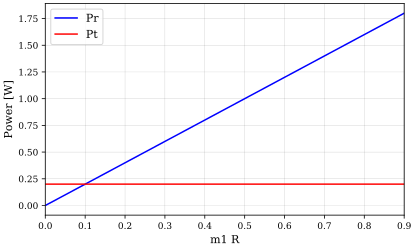

In [18]:
x1 = step_along('tune1', 'l1.P', np.linspace(0, 2, 4), False,
         on_complete=step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False))

sol = run(kat.model, x1)
res = sol.get('tune1')
res = sol.get('tune1/on_complete/tune2')
res.plot();

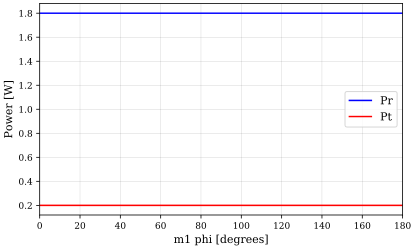

<ArraySolution of /tune1/tune2/tune3 @ 0x11fea1710 children=1>


In [24]:
x1 = step_along('tune1', 'l1.P', np.linspace(0, 2,   4), False)
x2 = step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False)
x3 = step_along('tune3', 'm1.phi', np.linspace(0, 180, 10), False)

my_analysis = serial(x1, x2, x3, x1)
    
sol = run(kat.model, my_analysis)
res = sol.get('/tune1/tune2')
res = sol.get('/tune1/tune2/tune3')
res.plot();
print(res)

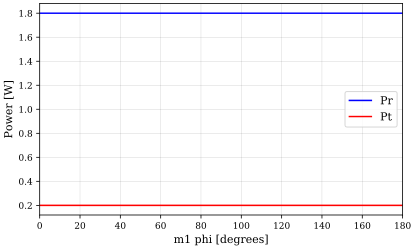

<ArraySolution of /tune1/tune2/tune3 @ 0x11ff28710 children=1>


In [25]:
x1 = step_along('tune1', 'l1.P', np.linspace(0, 2,   4), False)
x2 = step_along('tune2', 'm1.R', np.linspace(0, 0.9, 4), False)
x3 = step_along('tune3', 'm1.phi', np.linspace(0, 180, 10), False)

my_analysis = serial(x1, x2, x3, x1)
    
sol = run(kat.model, my_analysis)
res = sol.get('/tune1/tune2/tune3')
res.plot();
print(res)

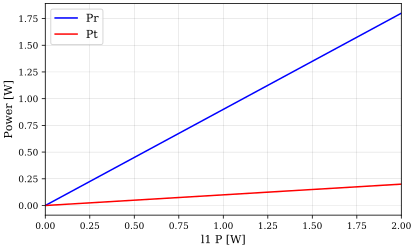

({finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>},
 {})

In [26]:
sol = run(kat.model, serial(x1, x1))
sol.get('tune1/tune1').plot()

In [ ]:
Could also put it in there, you'd then have something like:

def _on_build(self, sim):
    ws = sim.ws[self] = MirrorWorkspace()
    ws.Is = np.ones((sim.nhoms, 1))
    
    self._allocate_knm_matrices(sim, ws)
    # set attributes for complete scattering matrices and corresponding
    # losses for convenient access
    ws.K11 = ws.knm_matrices["K11"]
    ws.K12 = ws.knm_matrices["K12"]
    ws.K21 = ws.knm_matrices["K21"]
    ws.K22 = ws.knm_matrices["K22"]
    
    ws.K11_loss = ws.knm_losses["K11_loss"]
    ws.K12_loss = ws.knm_losses["K12_loss"]
    ws.K21_loss = ws.knm_losses["K21_loss"]
    ws.K22_loss = ws.knm_losses["K22_loss"]
    
def _on_unbuild(self, sim):
    del self.ws